In [ ]:
#https://github.com/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb

In [ ]:
!pip install transformers
!pip install demoji

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import AdamW
import time
import re
from nltk.corpus import stopwords
from string import punctuation


# Download NLTK stopwords
import nltk

device = torch.device("cuda")
print(device)

cuda


In [ ]:
df = pd.read_csv('train_dataset4.csv', encoding='latin-1')
df

,texts,labels
0,"I was born August 5, 1924, in Sacramento, Cal...",7
1,"I believe it was a midwife, because my birth ...",7
2,Aiko Yoshinaga.,7
3,"No, not at that time.",7
4,Yes. I had a couple of half sisters who I nev...,7
...,...,...
777,What?,7
778,"My mother, her name.",7
779,"Yes, it was, but this world is so full of var...",7
780,"Oh, that, I think it was Grandpa and Grandma....",7


In [ ]:
df['labels'].value_counts()

7    125
4    109
0     97
2     94
3     91
1     90
6     88
5     88
Name: labels, dtype: int64

In [ ]:
def preprocess_text(text):
    if not isinstance(text, str):
        return text

    text = text.lower()

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = re.sub(r'\s+', ' ', text).strip()

    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)

    text = ''.join(char for char in text if char not in punctuation)

    return text

def preprocess_column(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: preprocess_text(x))
    return df


nltk.download('stopwords')

df = preprocess_column(df, 'texts')
df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
texts = df['texts'].dropna()
labels = df['labels'].dropna().astype(int)

In [ ]:
texts

0                      born august sacramento california
1      believe midwife birth certificate says midwife...
2                                         aiko yoshinaga
3                                                   time
4      yes couple half sisters never met passed away ...
                             ...                        
777                                                     
778                                          mother name
779    yes world full variety mother angry said dont ...
780    oh think grandpa grandma dont know much though...
781                                                     
Name: texts, Length: 782, dtype: object

In [ ]:
#Split the data into training and temporary sets (80%)
train_text, temp_text, train_labels, temp_labels = train_test_split(
    texts, labels,
    random_state=42,
    test_size=0.8,
    stratify=labels
)
print(temp_labels.value_counts())

# Split the temporary set into validation and test sets (20%)
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels,
    random_state=42,
    test_size=0.2,
    stratify=temp_labels
)

#Displaying the shapes of the resulting sets
print("Shape of training text:", train_text.shape)
print("Shape of temporary text:", temp_text.shape)
print("Shape of validation text:", val_text.shape)
print("Shape of test text:", test_text.shape)
print("Shape of training labels:", train_labels.shape)
print("Shape of temporary labels:", temp_labels.shape)
print("Shape of validation labels:", val_labels.shape)
print("Shape of test labels:", test_labels.shape)


7    100
4     87
0     78
2     75
3     73
1     72
5     71
6     70
Name: labels, dtype: int64
Shape of training text: (156,)
Shape of temporary text: (626,)
Shape of validation text: (500,)
Shape of test text: (126,)
Shape of training labels: (156,)
Shape of temporary labels: (626,)
Shape of validation labels: (500,)
Shape of test labels: (126,)


In [ ]:
temp_labels

93     6
706    0
233    4
418    0
751    7
      ..
39     7
508    3
731    1
113    7
127    4
Name: labels, Length: 626, dtype: int64

In [ ]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
#Sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

#Encoding text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
print(sent_id)

In [ ]:
input_ids = sent_id.get('input_ids')

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


<Axes: >

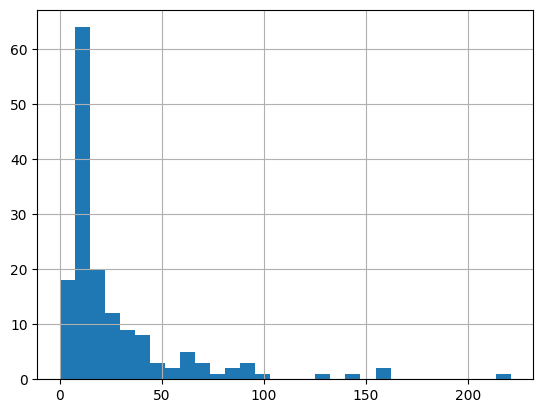

In [ ]:
#Showing length of all texts in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
#max_seq_len = max(seq_len)
max_seq_len = 25

In [ ]:
#Tokenizing and encoding sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

#Tokenizing and encoding sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

#Tokenizing and encoding sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
#For train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
print(type(train_mask))
print(type(train_seq))
train_y = torch.tensor(train_labels.tolist())

#For validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

#For test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#128,64,32
batch_size = 64

train_data = TensorDataset(train_seq, train_mask, train_y)

train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)

val_sampler = SequentialSampler(val_data)

val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 8

class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      self.dropout = nn.Dropout(0.1)

      self.relu =  nn.ReLU()

      self.fc1 = nn.Linear(768,512)

      self.fc2 = nn.Linear(512,8)

      self.softmax = nn.LogSoftmax(dim=1)

      self.fc = nn.Linear(bert.config.hidden_size, num_classes)

    def forward(self, sent_id, mask):
      output = self.bert(sent_id, attention_mask=mask, return_dict=False)
      cls_hs = output[0][:, 0, :]

      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)

      return x


In [ ]:
model = BERT_Arch(bert)

#Using GPU
model = model.to(device)

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
#Computing the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
print(class_wts)

[1.02631579 1.08333333 1.02631579 1.08333333 0.88636364 1.14705882
 1.08333333 0.78      ]


In [ ]:
#Converting class weights to tensor
#weights= torch.tensor(class_wts,dtype=torch.float)
num_classes = len(class_wts)
weights = torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)
print(weights)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)
print(cross_entropy)

tensor([1.0263, 1.0833, 1.0263, 1.0833, 0.8864, 1.1471, 1.0833, 0.7800],
       device='cuda:0')
NLLLoss()


In [ ]:
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  total_preds=[]

  for step,batch in enumerate(train_dataloader):

    #Progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    model.zero_grad()

    if not torch.is_tensor(sent_id):
        sent_id = torch.tensor(sent_id).to(device)
    if not torch.is_tensor(mask):
        mask = torch.tensor(mask).to(device)

    #Getting model predictions for the current batch
    preds = model(sent_id, mask)

    #Computing the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    #Adding on to the total loss
    total_loss = total_loss + loss.item()

    #Backward pass to calculate the gradients
    loss.backward()

    #Clipping the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    #Updating parameters
    optimizer.step()

    preds=preds.detach().cpu().numpy()
    total_preds.append(preds)

  #Computing the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  #Reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
def evaluate():

    print("\nEvaluating...")

    model.eval()

    total_loss, total_accuracy = 0, 0

    total_preds = []

    #Iterating over batches
    for step, batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        #if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
           # elapsed = format_time(time.time() - t0)

            # Report progress.
            #print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        if not torch.is_tensor(sent_id):
            sent_id = torch.tensor(sent_id).to(device)
        if not torch.is_tensor(mask):
            mask = torch.tensor(mask).to(device)

        with torch.no_grad():
            preds = model(sent_id, mask)

            #Computing the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    #Computing the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    #Reshaping the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


In [ ]:
#Setting initial loss to infinite
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]

epochs = 15

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss, _ = train()

    valid_loss, _ = evaluate()

    #Saving the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 15

Evaluating...

Training Loss: 0.806
Validation Loss: 1.083

 Epoch 2 / 15

Evaluating...

Training Loss: 0.747
Validation Loss: 1.073

 Epoch 3 / 15

Evaluating...

Training Loss: 0.670
Validation Loss: 1.013

 Epoch 4 / 15

Evaluating...

Training Loss: 0.602
Validation Loss: 0.998

 Epoch 5 / 15

Evaluating...

Training Loss: 0.584
Validation Loss: 0.976

 Epoch 6 / 15

Evaluating...

Training Loss: 0.486
Validation Loss: 0.978

 Epoch 7 / 15

Evaluating...

Training Loss: 0.463
Validation Loss: 0.996

 Epoch 8 / 15

Evaluating...

Training Loss: 0.424
Validation Loss: 0.969

 Epoch 9 / 15

Evaluating...

Training Loss: 0.381
Validation Loss: 0.970

 Epoch 10 / 15

Evaluating...

Training Loss: 0.389
Validation Loss: 0.960

 Epoch 11 / 15

Evaluating...

Training Loss: 0.347
Validation Loss: 0.997

 Epoch 12 / 15

Evaluating...

Training Loss: 0.322
Validation Loss: 0.965

 Epoch 13 / 15

Evaluating...

Training Loss: 0.271
Validation Loss: 0.989

 Epoch 14 / 15

Eval

In [ ]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

#Showing the model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.92      0.75      0.83        16
           1       0.52      0.79      0.63        14
           2       0.53      0.53      0.53        15
           3       0.75      0.80      0.77        15
           4       0.75      0.67      0.71        18
           5       0.87      0.93      0.90        14
           6       0.83      0.71      0.77        14
           7       0.78      0.70      0.74        20

    accuracy                           0.73       126
   macro avg       0.74      0.73      0.73       126
weighted avg       0.75      0.73      0.73       126



In [ ]:
best_model_path = 'saved_weights.pt'
best_model = BERT_Arch(bert)
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)
best_model.eval()

#all_predictions = predict_labels(best_model, actual_dataloader, device)

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [ ]:
#Confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1,2,3,4,5,6,7
row_0,,,,,,,,
0,12,1,1,0,1,0,1,0
1,0,11,1,2,0,0,0,0
2,0,4,8,0,1,0,0,2
3,0,0,1,12,1,1,0,0
4,0,0,1,2,12,0,1,2
5,0,0,1,0,0,13,0,0
6,1,1,1,0,0,1,10,0
7,0,4,1,0,1,0,0,14


In [ ]:
#Applying to the different dataset
sample_df = pd.read_csv('interviewer_testdataset1.csv', encoding='latin-1')
#transcripts = sample_df['Transcript (Narrator)'].dropna().astype(str)
labels = sample_df['labels'].dropna().astype(int)

In [ ]:
sample_df

,texts,labels
0,"Emi Kuboyama here in Washington, D.C., with A...",4.0
1,"No, I started at DOL (Department of Labor).",4.0
2,"I don't remember, but I know it was based on ...",4.0
3,Were these always in conjunction with JACL or...,4.0
4,Citizens League. Were they all part of the co...,4.0
...,...,...
818,Were there any unexpected positive outcomes or...,5.0
819,How did the government's decision affect the p...,5.0
820,Did you receive any restitution or apology fro...,5.0
821,Can you discuss the impact of the internment o...,5.0


In [ ]:
#no
nltk.download('stopwords')

# Preprocess the 'TextColumn'
sample_df = preprocess_column(sample_df, 'texts')

# Display the DataFrame after preprocessing
print(sample_df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: ignored

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Custom Dataset class
class MyDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['texts'])  # Convert to string
        label = 0  # Set a default label value (replace with an appropriate default)

        # Tokenize and pad the text
        tokens = self.tokenizer(text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')

        # Return input data and label
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'label': label,
        }

def predict_labels(model, dataloader, device):
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            # Move data to the device
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            # Run inference
            predictions = model(sent_id=input_ids, mask=attention_mask)

             #Post-process predictions if needed
            predictions = torch.argmax(predictions, dim=1).cpu().numpy()

             #Accumulate predictions
            all_predictions.extend(predictions)

    return np.array(all_predictions)

def add_predicted_labels_to_dataframe(df, predictions, text_column='texts', label_column='predicted_labels'):
    mask = df[text_column].notna()
    df[label_column] = np.where(df[text_column].notna(), predictions, np.nan)
    df[label_column] = df[label_column].astype('Int64')  # Convert to nullable integers
    return df

max_length = 128
my_dataset = MyDataset(data=sample_df, tokenizer=tokenizer, max_length=max_length)

batch_size = 64
actual_dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=False)

all_predictions = predict_labels(best_model, actual_dataloader, device)
sample_df = add_predicted_labels_to_dataframe(sample_df, all_predictions)

print(sample_df)

ground_truth_labels = sample_df['labels'].to_numpy()

accuracy = accuracy_score(ground_truth_labels, all_predictions)

print(f"Accuracy: {accuracy * 100:.2f}%")


#73.53% (Alice Kale)
#69.3(June Aragaki)
#44.44


#74.12
#61.76
#52.43
#1125 BAD

NameError: ignored

In [ ]:
# Save the DataFrame to a CSV file
sample_df.to_csv('sample_classified_result.csv', index=False, encoding = 'utf-8')


In [ ]:
# Custom Dataset class
class MyDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['Transcript (Interviewer)'])  # Convert to string
        label = 0  # Set a default label value (replace with an appropriate default)

        # Tokenize and pad the text
        tokens = self.tokenizer(text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')

        # Return input data and label
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'label': label,
        }

def predict_labels(model, dataloader, device):
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            # Move data to the device
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            # Run inference
            predictions = model(sent_id=input_ids, mask=attention_mask)

             #Post-process predictions if needed
            predictions = torch.argmax(predictions, dim=1).cpu().numpy()

             #Accumulate predictions
            all_predictions.extend(predictions)

    return np.array(all_predictions)

def add_predicted_labels_to_dataframe(df, predictions, text_column='Transcript (Interviewer)', label_column='predicted_labels'):
    mask = df[text_column].notna()
    df[label_column] = np.where(df[text_column].notna(), predictions, np.nan)
    df[label_column] = df[label_column].astype('Int64')  # Convert to nullable integers
    return df

In [ ]:
def preprocess_column(df, column_name, new_column_name):
    df[new_column_name] = df[column_name].apply(lambda x: preprocess_text(x))
    return df

In [ ]:
#Accuracy 74%
import os
import zipfile
import pandas as pd
nltk.download('stopwords')

zip_file_name = 'JASC_Transcript.zip'

output_zip_file = 'Category_Labeled_JASC(Interviewer).zip'
temp_dir = 'temp_dir'
os.makedirs(temp_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_name, 'r') as zip_file:
    with zipfile.ZipFile(output_zip_file, 'w') as output_zip:
        for filename in zip_file.namelist():
            if filename.endswith('.csv'):
                with zip_file.open(filename) as csv_file:
                    df = pd.read_csv(csv_file, encoding='latin1')

                    processed_df = preprocess_column(df, 'Transcript (Interviewer)', 'Cleaned Transcript (Interviewer)')

                    max_length = 128
                    my_dataset = MyDataset(data=processed_df, tokenizer=tokenizer, max_length=max_length)
                    actual_dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=False)
                    all_predictions = predict_labels(best_model, actual_dataloader, device)
                    processed_df = add_predicted_labels_to_dataframe(processed_df, all_predictions)

                    temp_csv_path = os.path.join(temp_dir, filename)
                    df.to_csv(temp_csv_path, index=False)

                    output_zip.write(temp_csv_path, arcname=filename)

                    os.remove(temp_csv_path)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
